In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
def sarimax_grid_search(
    y,
    exog=None,
    p_range=(0, 3),
    d_range=(0, 1),
    q_range=(0, 3),
    P_range=(0, 2),
    D_range=(0, 1),
    Q_range=(0, 2),
    seasonal_period=12,
    train_ratio=0.8,
    selection_metric="RMSE",
    plot=True
):

    # Ensure datetime index
    if not isinstance(y.index, pd.DatetimeIndex):
        y = y.copy()
        y.index = pd.to_datetime(y.index)

    # Train-test split
    split = int(len(y) * train_ratio)
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    if exog is not None:
        X_train, X_test = exog.iloc[:split], exog.iloc[split:]
    else:
        X_train = X_test = None

    best_model = None
    best_score = np.inf
    best_params = None
    best_forecast = None
    best_metrics = None

    print("Starting Grid Search...")
    print("-" * 60)

    for p in range(p_range[0], p_range[1] + 1):
        for d in range(d_range[0], d_range[1] + 1):
            for q in range(q_range[0], q_range[1] + 1):
                for P in range(P_range[0], P_range[1] + 1):
                    for D in range(D_range[0], D_range[1] + 1):
                        for Q in range(Q_range[0], Q_range[1] + 1):

                            order = (p, d, q)
                            seasonal_order = (P, D, Q, seasonal_period)

                            try:
                                model = SARIMAX(
                                    y_train,
                                    exog=X_train,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=True,
                                    enforce_invertibility=True
                                )
                                model_fit = model.fit(disp=False)

                                forecast = model_fit.predict(
                                    start=y_test.index[0],
                                    end=y_test.index[-1],
                                    exog=X_test
                                )

                                mae = mean_absolute_error(y_test, forecast)
                                rmse = np.sqrt(mean_squared_error(y_test, forecast))
                                mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
                                r2 = r2_score(y_test, forecast)

                                # SELECT METRIC
                                if selection_metric == "RMSE":
                                    score = rmse
                                elif selection_metric == "MAE":
                                    score = mae
                                elif selection_metric == "MAPE":
                                    score = mape
                                elif selection_metric == "R2":
                                    score = -r2
                                else:
                                    raise ValueError("Invalid selection_metric")

                                # UPDATE BEST MODEL
                                if score < best_score:
                                    best_score = score
                                    best_model = model_fit
                                    best_params = {
                                        "order": order,
                                        "seasonal_order": seasonal_order
                                    }
                                    best_forecast = forecast
                                    best_metrics = {
                                        "MAE": mae,
                                        "RMSE": rmse,
                                        "MAPE (%)": mape,
                                        "R2": r2
                                    }

                            except Exception:
                                continue

    print("\nGRID SEARCH COMPLETE")
    print("Best Params:", best_params)
    print("Best Metric Score:", best_score)
    print("Metrics:", best_metrics)

   
    if plot and best_model is not None:

        residuals = best_model.resid

      
        plt.figure(figsize=(12, 5))
        plt.plot(y_train, label="Train")
        plt.plot(y_test, label="Test")
        plt.plot(best_forecast, label="Best Forecast", linestyle="--")
        plt.title(f"Best SARIMAX Model: {best_params}")
        plt.legend()
        plt.show()

       
        plt.figure(figsize=(12, 4))
        plt.plot(residuals)
        plt.axhline(0, color="black", linewidth=1)
        plt.title("Residual Plot")
        plt.show()

        fig, ax = plt.subplots(figsize=(12, 4))
        sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=len(residuals) - 1)
        plt.title("ACF of Residuals")
        plt.show()

    return best_model, best_params, best_forecast, best_metrics

In [4]:
# reading the dataset
df = pd.read_csv('Database.csv')
df.head()

,Unnamed: 0,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,0,2019-01-01-T00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2810,22216
1,1,2019-01-01-T00:05,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2862,22106
2,2,2019-01-01-T00:10,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0,2916,22130
3,3,2019-01-01-T00:15,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0,2920,22040
4,4,2019-01-01-T00:20,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0,2902,21963


In [5]:
# droping redundant index column
df = df.drop(columns = ['Unnamed: 0'])

# checking the datatypes of the columns
print(df.info())

# converting the datatype of time column to datatime
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index("Time")
# extracting attributes from Time attribute
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Date'] = df.index.date

# Removing negative values in energy production series
df['PV_production'] = abs(df['PV_production'])
df['Wind_production'] = abs(df['Wind_production'])

# Combining the energy generated by both sources
df['Energy_produced'] = df['PV_production'] + df['Wind_production']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             315648 non-null  object 
 1   Season           315648 non-null  int64  
 2   Day_of_the_week  315648 non-null  int64  
 3   DHI              315648 non-null  float64
 4   DNI              315648 non-null  float64
 5   GHI              315648 non-null  float64
 6   Wind_speed       315648 non-null  float64
 7   Humidity         315648 non-null  float64
 8   Temperature      315648 non-null  float64
 9   PV_production    315648 non-null  int64  
 10  Wind_production  315648 non-null  int64  
 11  Electric_demand  315648 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 28.9+ MB
None


Starting Grid Search...
------------------------------------------------------------

GRID SEARCH COMPLETE
Best Params: {'order': (0, 1, 3), 'seasonal_order': (1, 0, 2, 12)}
Best Metric Score: 244.46571188380022
Metrics: {'MAE': 196.1057599604449, 'RMSE': np.float64(244.46571188380022), 'MAPE (%)': np.float64(6.043649039061692), 'R2': 0.9426813900071278}


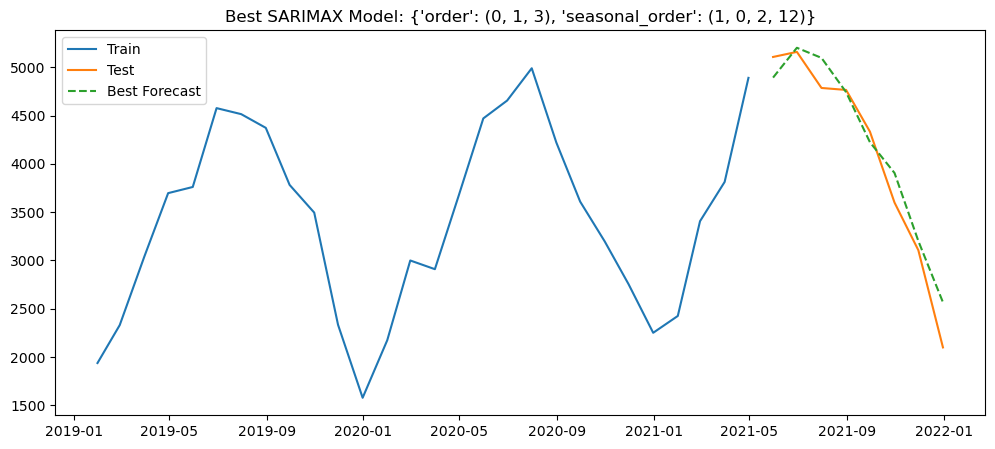

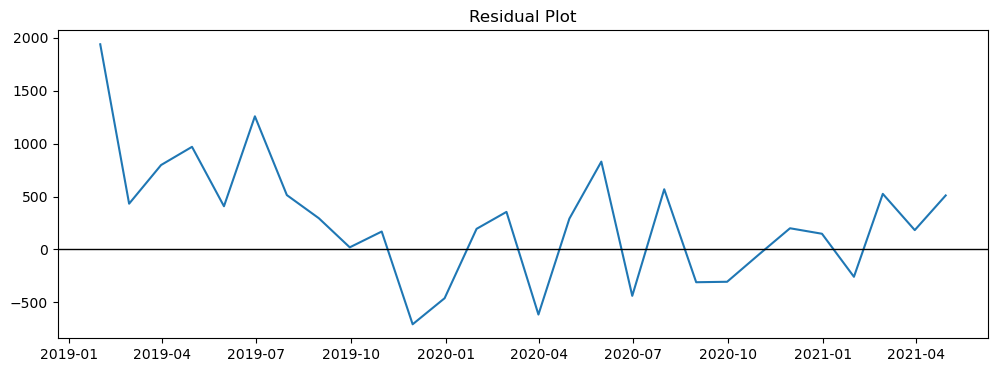

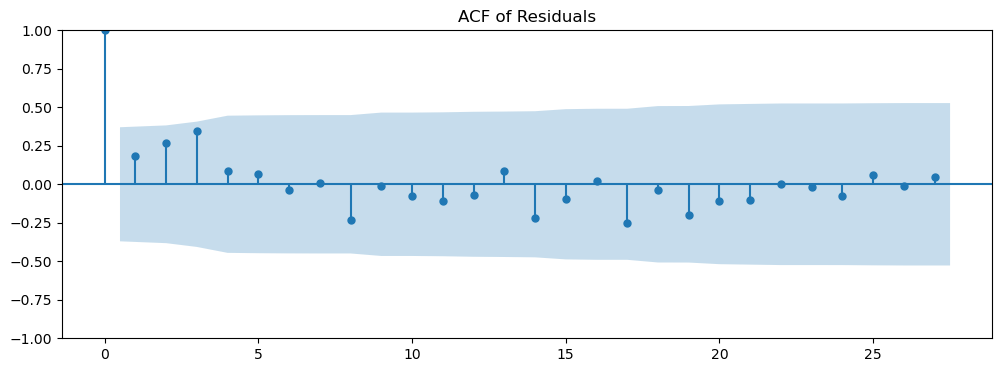

In [11]:
# PV forcasting without exogenous variables

pv_best_model, pv_best_params, pv_best_forecast,pv_best_metrics= sarimax_grid_search(df['PV_production'].resample('M').mean())


Starting Grid Search...
------------------------------------------------------------


/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-p


GRID SEARCH COMPLETE
Best Params: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 0, 12)}
Best Metric Score: 86.01735648412665
Metrics: {'MAE': 73.05513540081597, 'RMSE': np.float64(86.01735648412665), 'MAPE (%)': np.float64(2.0393435930812904), 'R2': 0.9929037007136259}


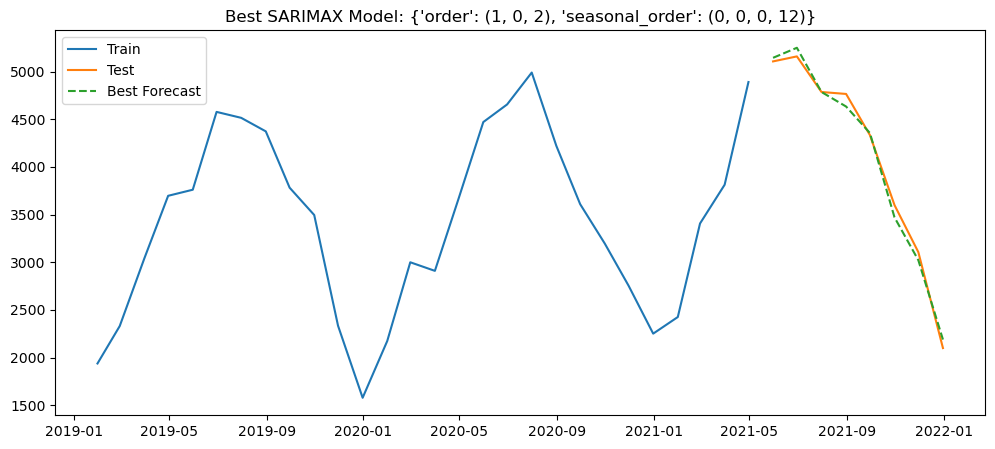

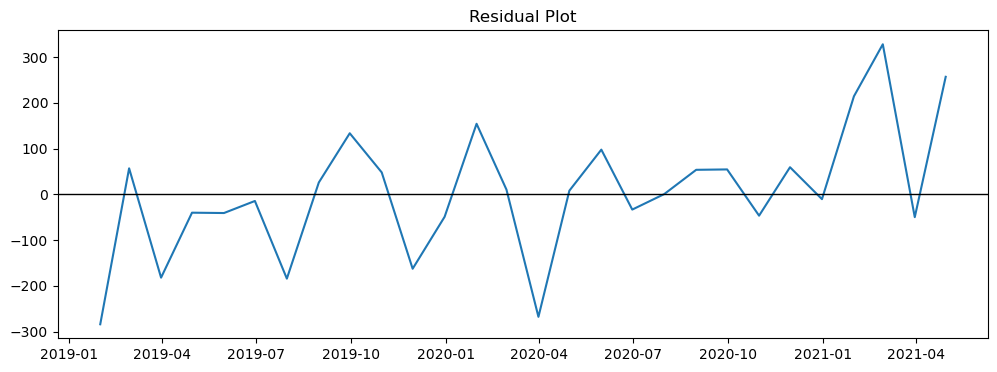

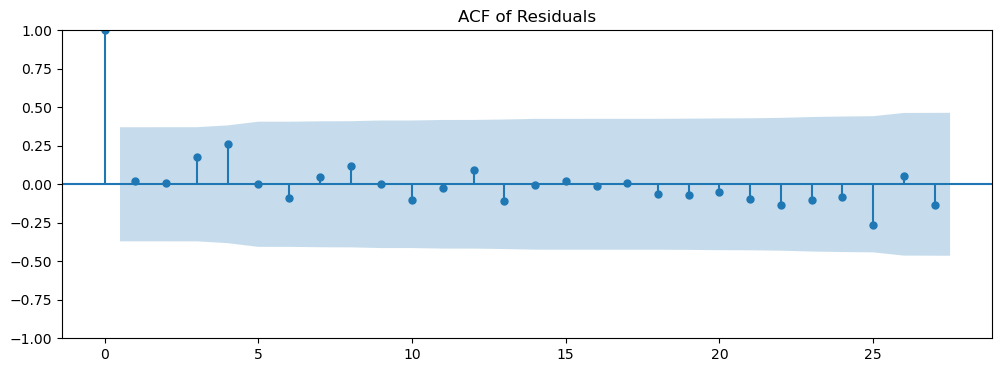

In [6]:
# pv production with exogenous attributes
pv_exo_var = ['DHI', 'DNI', 'GHI', 'Temperature','Humidity']
pv_x_best_model, pv_x_best_params, pv_x_best_forecast,pv_x_best_metrics= sarimax_grid_search(df['PV_production'].resample('M').mean(), df[pv_exo_var].resample('M').mean())

Starting Grid Search...
------------------------------------------------------------

GRID SEARCH COMPLETE
Best Params: {'order': (3, 0, 1), 'seasonal_order': (1, 0, 1, 12)}
Best Metric Score: 185.00001963659068
Metrics: {'MAE': 134.38740185109666, 'RMSE': np.float64(185.00001963659068), 'MAPE (%)': np.float64(7.125521325984599), 'R2': 0.8993451570829161}


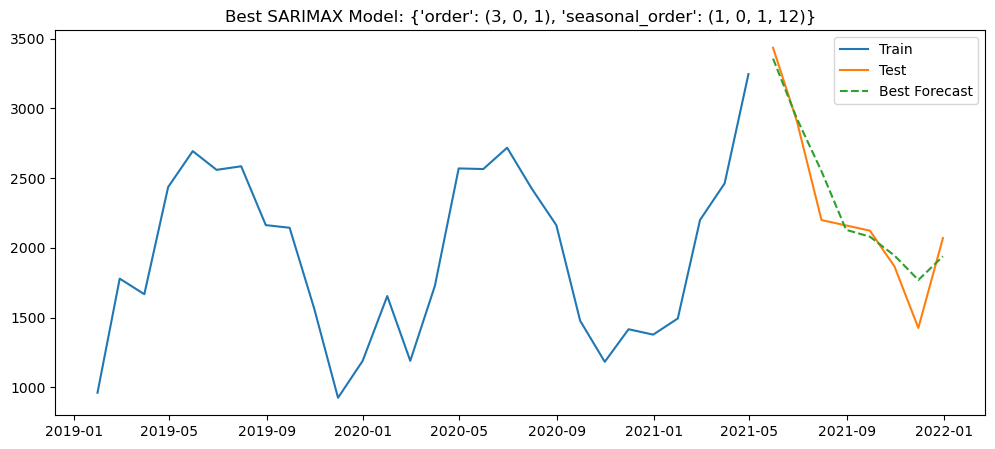

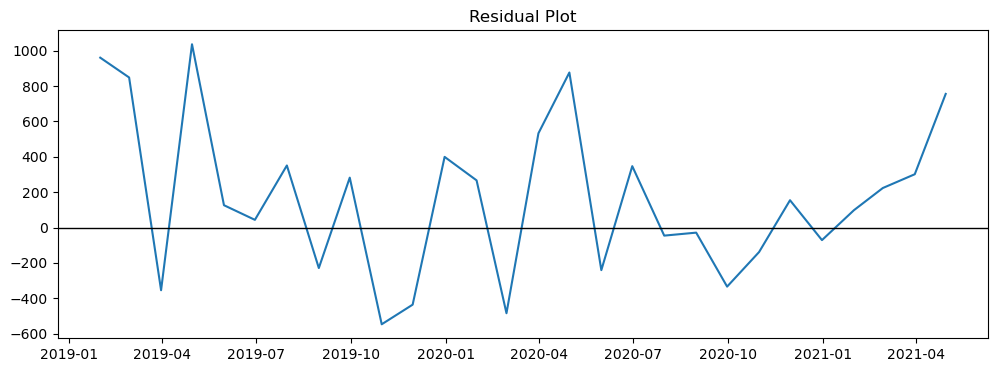

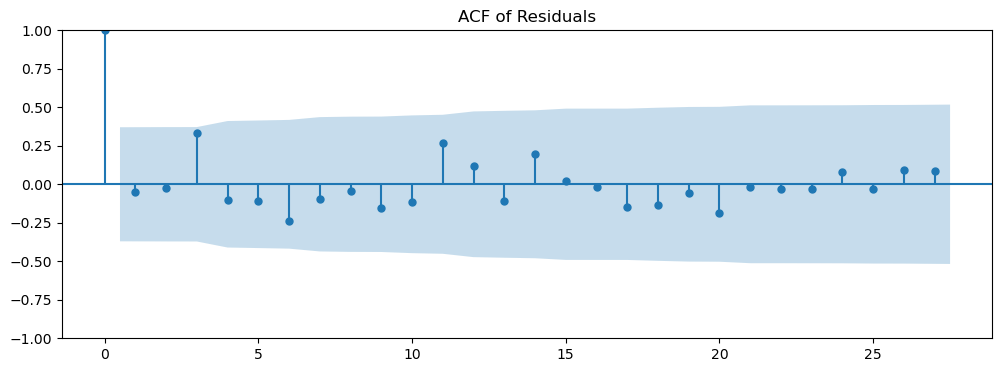

In [13]:
# Wind forcasting without exogenous variables

wind_best_model, wind_best_params, wind_best_forecast,wind_best_metrics= sarimax_grid_search(df['Wind_production'].resample('M').mean())

Starting Grid Search...
------------------------------------------------------------


/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/chandaluri/anaconda3/lib/python3.13/site-p


GRID SEARCH COMPLETE
Best Params: {'order': (1, 0, 1), 'seasonal_order': (0, 0, 0, 12)}
Best Metric Score: 189.505644960977
Metrics: {'MAE': 166.4078303882159, 'RMSE': np.float64(189.505644960977), 'MAPE (%)': np.float64(7.649717293211265), 'R2': 0.8943826105559771}


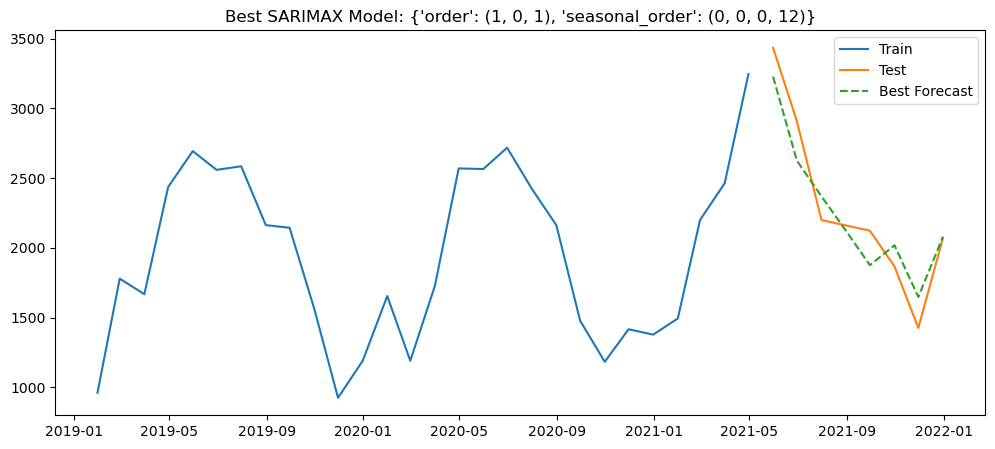

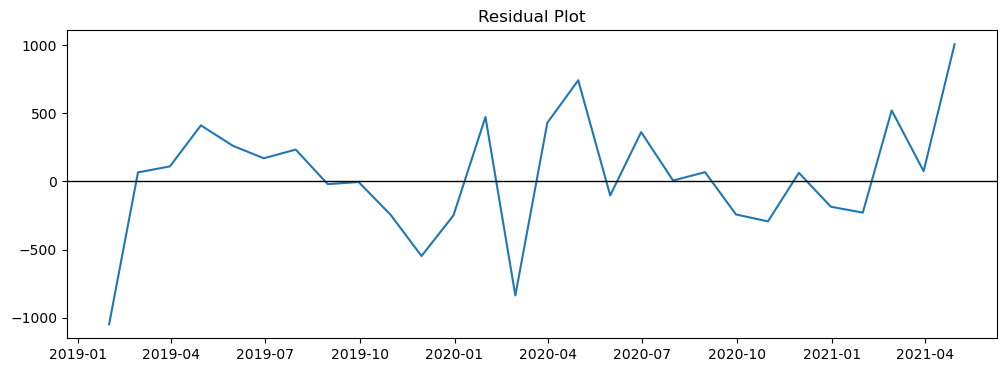

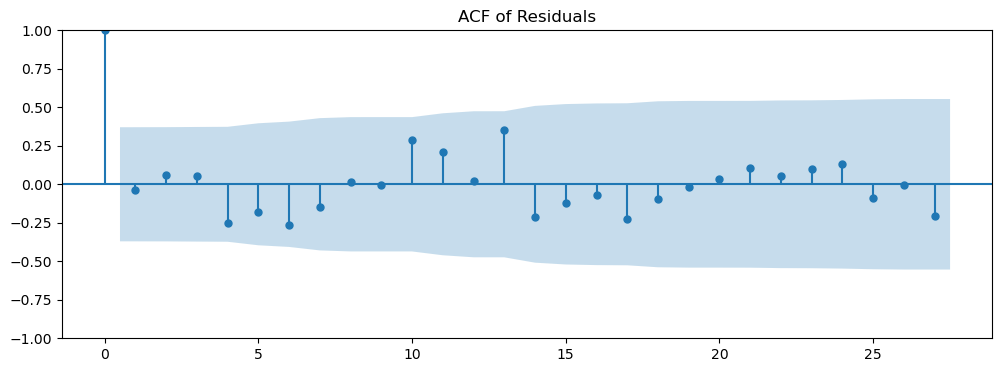

In [8]:
# wind production with exogenous attributes
wind_exo_var = ['Wind_speed', 'Humidity']
wind_x_best_model, wind_x_best_params, wind_x_best_forecast,wind_x_best_metrics= sarimax_grid_search(df['Wind_production'].resample('M').mean(), df[wind_exo_var].resample('M').mean())

Starting Grid Search...
------------------------------------------------------------

GRID SEARCH COMPLETE
Best Params: {'order': (1, 0, 2), 'seasonal_order': (1, 0, 2, 12)}
Best Metric Score: 924.8365680156447
Metrics: {'MAE': 782.8281131696158, 'RMSE': np.float64(924.8365680156447), 'MAPE (%)': np.float64(2.9033789209735055), 'R2': 0.8966700682220998}


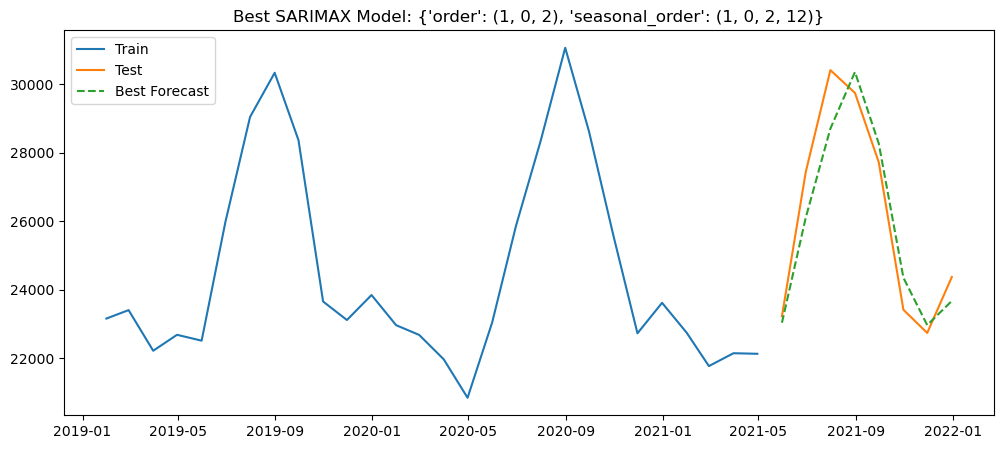

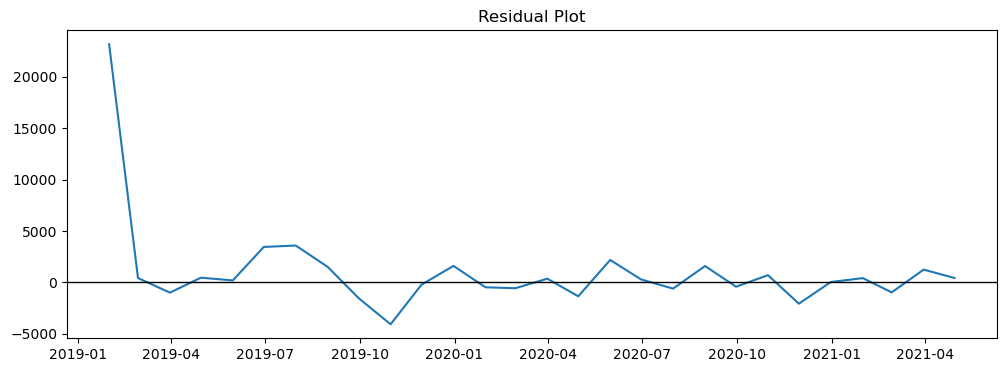

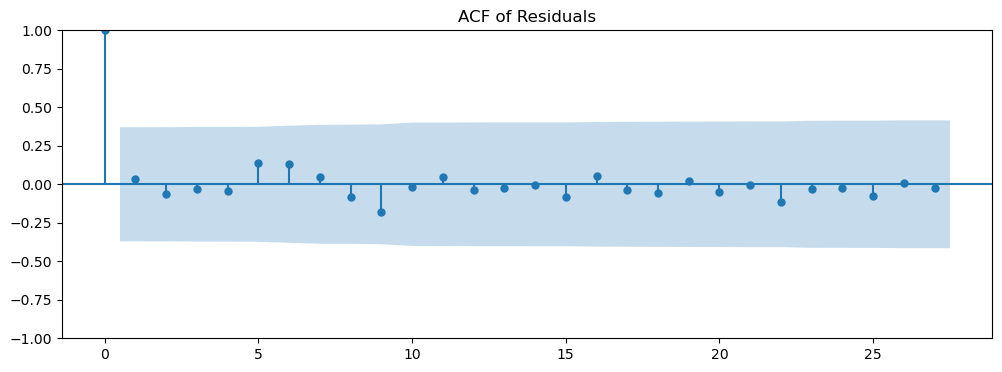

In [15]:
# electric forcasting without exogenous variables

electric_best_model, electric_best_params, electric_best_forecast,electric_best_metrics= sarimax_grid_search(df['Electric_demand'].resample('M').mean())

Starting Grid Search...
------------------------------------------------------------

GRID SEARCH COMPLETE
Best Params: {'order': (0, 0, 3), 'seasonal_order': (1, 1, 0, 12)}
Best Metric Score: 898.7195550078351
Metrics: {'MAE': 794.1783795988699, 'RMSE': np.float64(898.7195550078351), 'MAPE (%)': np.float64(2.9749185872010124), 'R2': 0.9024236566893135}


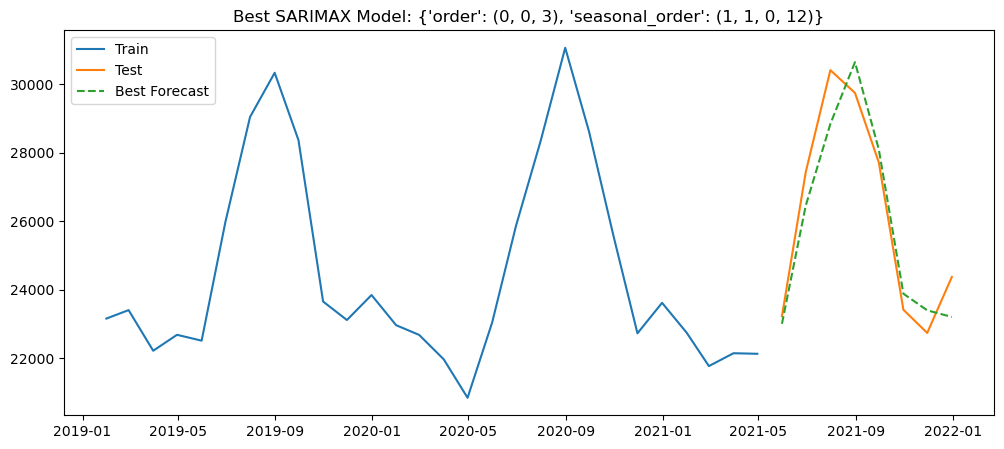

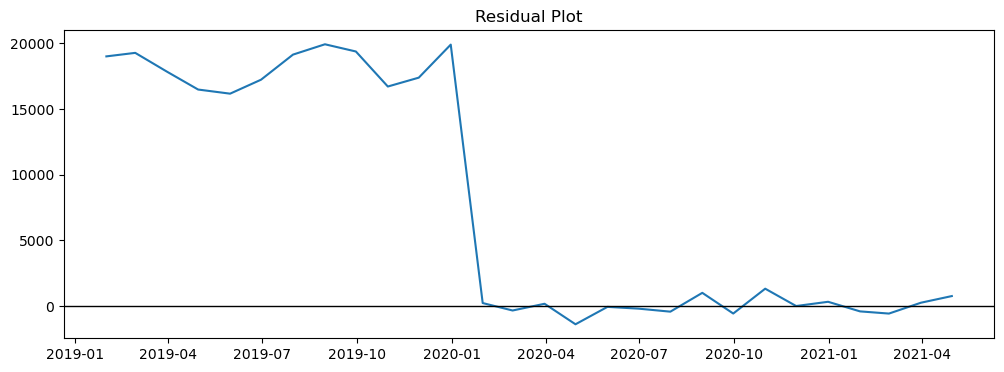

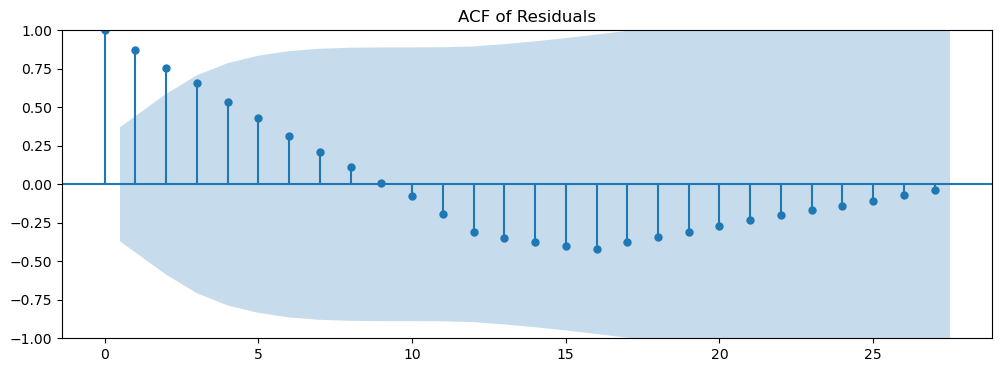

In [16]:
# electric production with exogenous attributes
electric_exo_var = ['Temperature']
electric_x_best_model, electric_x_best_params, electric_x_best_forecast,electric_x_best_metrics= sarimax_grid_search(df['Electric_demand'].resample('M').mean(), df[electric_exo_var].resample('M').mean())